# Hard EM - VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

# Fitting a distribution $q_n$ given $\boldsymbol\theta$

In this section, we find a variational distribution $q_n$ for $\boldsymbol\theta_\text{vae}$ and $\boldsymbol\theta_\text{hard-em}$. We consider a dataset ${\bf X}_\text{test}$ and train an unamortised variational distribution of the form

$$
    q_n(z_n) = \mathcal{N}(z_n \vert \mu_n, \sigma_n)
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "1"

In [3]:
import jax
import hlax
import json
import glob
import tomli
import pickle
import distrax
import flax.linen as nn
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import List, Tuple

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [6]:
def build_mll_summary(res, procedure):
    df_mll = pd.DataFrame(res["test"]).melt(var_name="episode", value_name="mll")
    df_mll["procedure"] = procedure

    df_times = pd.DataFrame.from_dict({"times": res["train"]["times"]}, orient="index").T
    df_mll = pd.merge(df_mll, df_times, left_on="episode", right_index=True)
    return df_mll

## Load base configuration

In [8]:
path_config = "../experiments/configs/fmnist-conv01.toml"
with open(path_config, "rb") as f:
    config_str = f.read().decode("utf-8")
    config = tomli.loads(config_str)

print(config_str)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[train]
    num_obs = 10_000
    num_epochs = 3000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000]
    learning_rate = 1e-6 # For VAE and HardEM

    [train.vae]
        num_is_samples = 10
    [train.hard_em]
        num_its_latent = 10 # E-step
        num_its_params = 5 # M-step

[test]
    num_obs = 1000
    num_epochs = 500
    learning_rate = 1e-6
    num_is_samples = 10


## Base models

In [7]:
class ConvEncoder(nn.Module):
    latent_dim: Tuple

    @nn.compact
    def __call__(self, x):
        z = nn.Conv(5, (3, 3), padding="SAME")(x)
        z = nn.elu(z)
        z = nn.max_pool(z, (2, 2), padding="SAME")
        z = z.reshape((z.shape[0], -1))
        z = nn.Dense(self.latent_dim)(z)

        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z


class ConvDecoder(nn.Module):
    dim_obs: List
    dim_latent: int

    @nn.compact
    def __call__(self, z):
        x = nn.Dense(28 ** 2)(z)
        x = x.reshape(*z.shape[:-1], *(28, 28, 1))
        x = nn.elu(x)
        x = nn.Conv(5, (3, 3), padding="SAME")(x)
        x = nn.elu(x)
        x = nn.Conv(1, (3, 3), padding="SAME")(x)
        return x

## Loss functions

In [55]:
def neg_iwmll_bern(key, params_encoder, params_decoder, observation,
              encoder, decoder, num_is_samples=10):
    """
    Importance-weighted marginal log-likelihood for an unamortised, uncoditional
    gaussian encoder.
    """
    latent_samples, (mu_z, std_z) = encoder.apply(
        params_encoder, key, num_samples=num_is_samples
    )

    _, dim_latent = latent_samples.shape
    # log p(x|z)
    logit_mean_x = decoder.apply(params_decoder, latent_samples)
    log_px_cond = distrax.Bernoulli(logits=logit_mean_x).log_prob(observation).sum(axis=(-1, -2, -3))

    # log p(z)
    mu_z_init, std_z_init = jnp.zeros(dim_latent), jnp.ones(dim_latent)
    log_pz = distrax.MultivariateNormalDiag(mu_z_init, std_z_init).log_prob(latent_samples)

    # log q(z)
    log_qz = distrax.MultivariateNormalDiag(mu_z, std_z).log_prob(latent_samples)

    # Importance-weighted marginal log-likelihood
    log_prob = log_pz + log_px_cond - log_qz
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples)
    return niwmll


def iwae_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder
    """
    batch_size = len(X_batch)

    # keys = jax.random.split(key, batch_size)
    # encode_decode = jax.vmap(apply_fn, (None, 0, 0))
    # encode_decode = encode_decode(params, X_batch, keys)
    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)

    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=(-1, -2, -3))
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post

    # negative Importance-weighted marginal log-likelihood
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).mean()
    return niwmll


def hard_nmll_bern(params, z_batch, X_batch, model):
    """
    Loss function
    -------------

    Negative Marginal log-likelihood for hard EM
    assuming an isotropic Gaussian prior with zero mean
    and a decoder with a diagonal covariance matrix

    Parameters
    ----------
    params: pytree
        Parameters of the decoder model, i.e.,
        model.apply(params, z_batch) = X_batch (approx)
    z_batch: jnp.ndarray
        Batch of latent variables
    X_batch: jnp.ndarray
        Batch of observations
    model: flax.nn.Module
        Decoder model (input z -> output x)
    """
    dim_latent = model.dim_latent
    logit_mean_x = model.apply(params, z_batch)

    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)

    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=(-1, -2, -3))

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

In [10]:
grad_neg_iwmll_encoder = jax.value_and_grad(neg_iwmll_bern, argnums=1)
vmap_neg_iwmll = jax.vmap(neg_iwmll_bern, (0, 0, None, 0, None, None, None))

lossfn_vae = iwae_bern
lossfn_hardem = hard_nmll_bern

## Setup

In [11]:
key = jax.random.PRNGKey(314)
key_hardem, key_vae = jax.random.split(key)

In [72]:
num_train = config["train"]["num_obs"]
num_test = config["test"]["num_obs"]
train, test = hlax.datasets.load_fashion_mnist(num_train, num_test, melt=False, normalize=False)
X_train, X_test = train[0], test[0]
# Add number of input channels: 1
# Make the input a binary variable
X_train = X_train[..., None].round()
X_test = X_test[..., None].round()

In [74]:
num_obs, *dim_obs = X_test.shape

In [75]:
dim_latent = config["setup"]["dim_latent"]
model_vae = hlax.models.VAEBern(dim_latent, dim_obs, ConvEncoder, ConvDecoder)
model_decoder = ConvDecoder(1, dim_latent)
model_encoder_test = hlax.models.GaussEncoder(dim_latent)
    
config_vae, config_hardem, config_test = base_vae_hardem.setup(config, model_vae, model_decoder, model_encoder_test)

In [76]:
_, *dim_obs = X_train.shape
dim_latent = config["setup"]["dim_latent"]
model_vae = hlax.models.VAEBern(dim_latent, dim_obs, ConvEncoder, ConvDecoder)
model_decoder = ConvDecoder(1, dim_latent)
model_encoder_test = hlax.models.GaussEncoder(dim_latent)

# Initial Test

### VAE training

In [96]:
%%time
res_vae = base_vae_hardem.train_test(key_vae, X_train, X_test, config_vae, config_test,
                     iwae_bern, vmap_neg_iwmll, grad_neg_iwmll_encoder, hlax.vae.train_checkpoints)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 5min 28s, sys: 1min 10s, total: 6min 38s
Wall time: 21min 22s


### Unamortised VAE training 

### Hard EM - LVM training

In [79]:
%%time
res_hemlvm = base_vae_hardem.train_test(key_hardem, X_train, X_test, config_hardem, config_test, 
                        hard_nmll_bern, vmap_neg_iwmll, grad_neg_iwmll_encoder, hlax.hard_em_lvm.train_checkpoints)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 6min 30s, sys: 1min 58s, total: 8min 29s
Wall time: 23min 35s


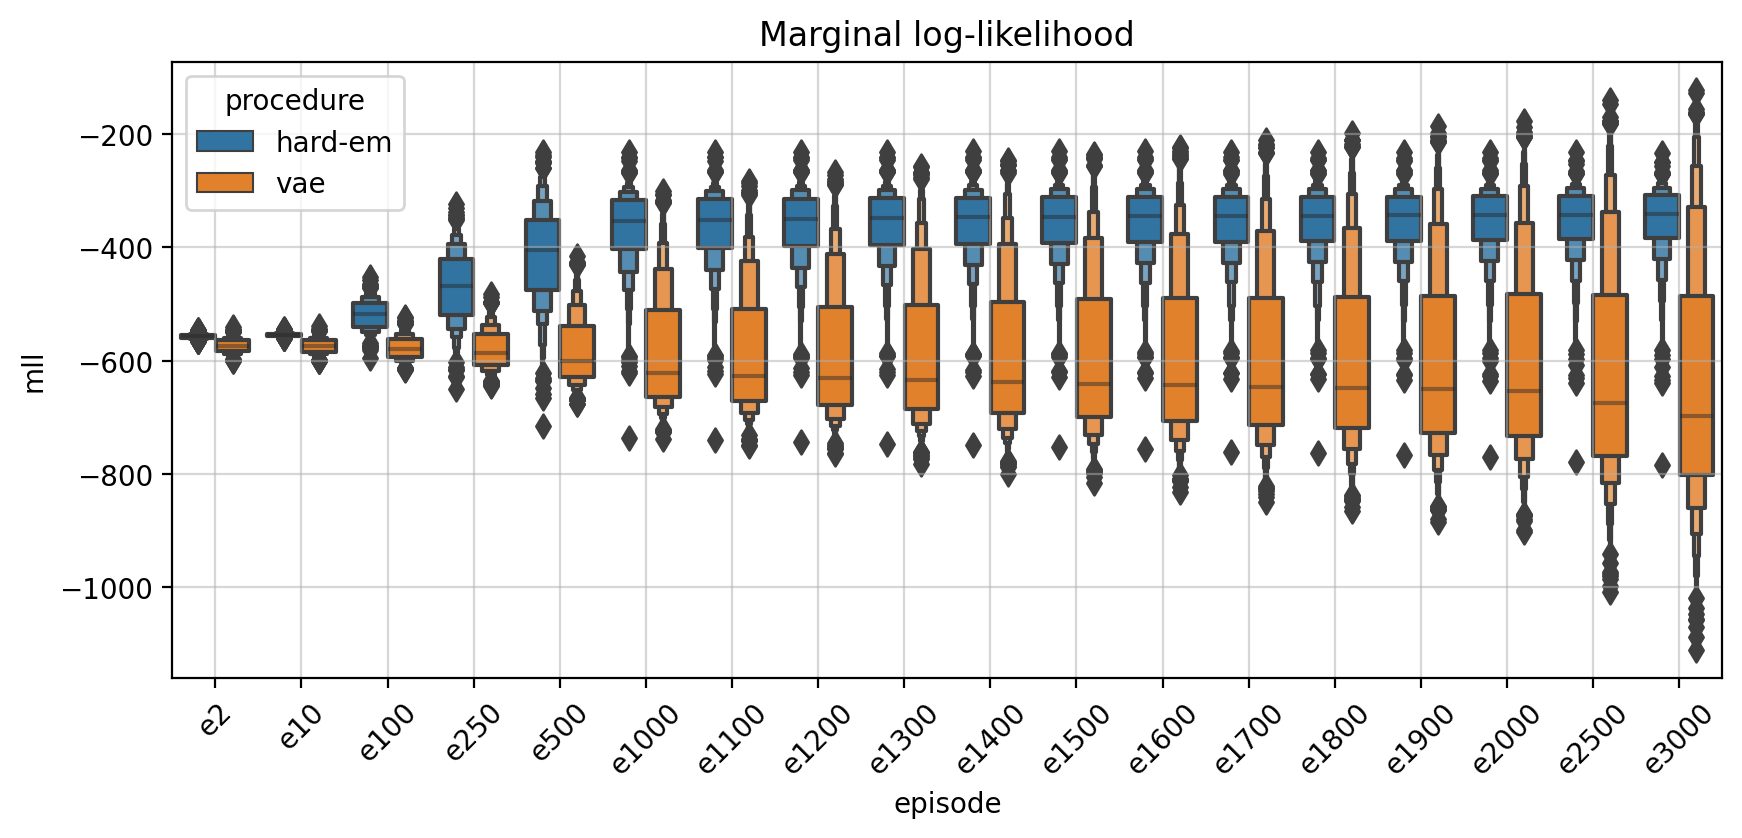

In [80]:
df_vae = build_mll_summary(res_vae, "vae")
df_hem = build_mll_summary(res_hemlvm, "hard-em")
df_all = pd.concat([df_hem, df_vae])

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x="episode", y="mll", hue="procedure", data=df_all)
plt.title("Marginal log-likelihood")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)

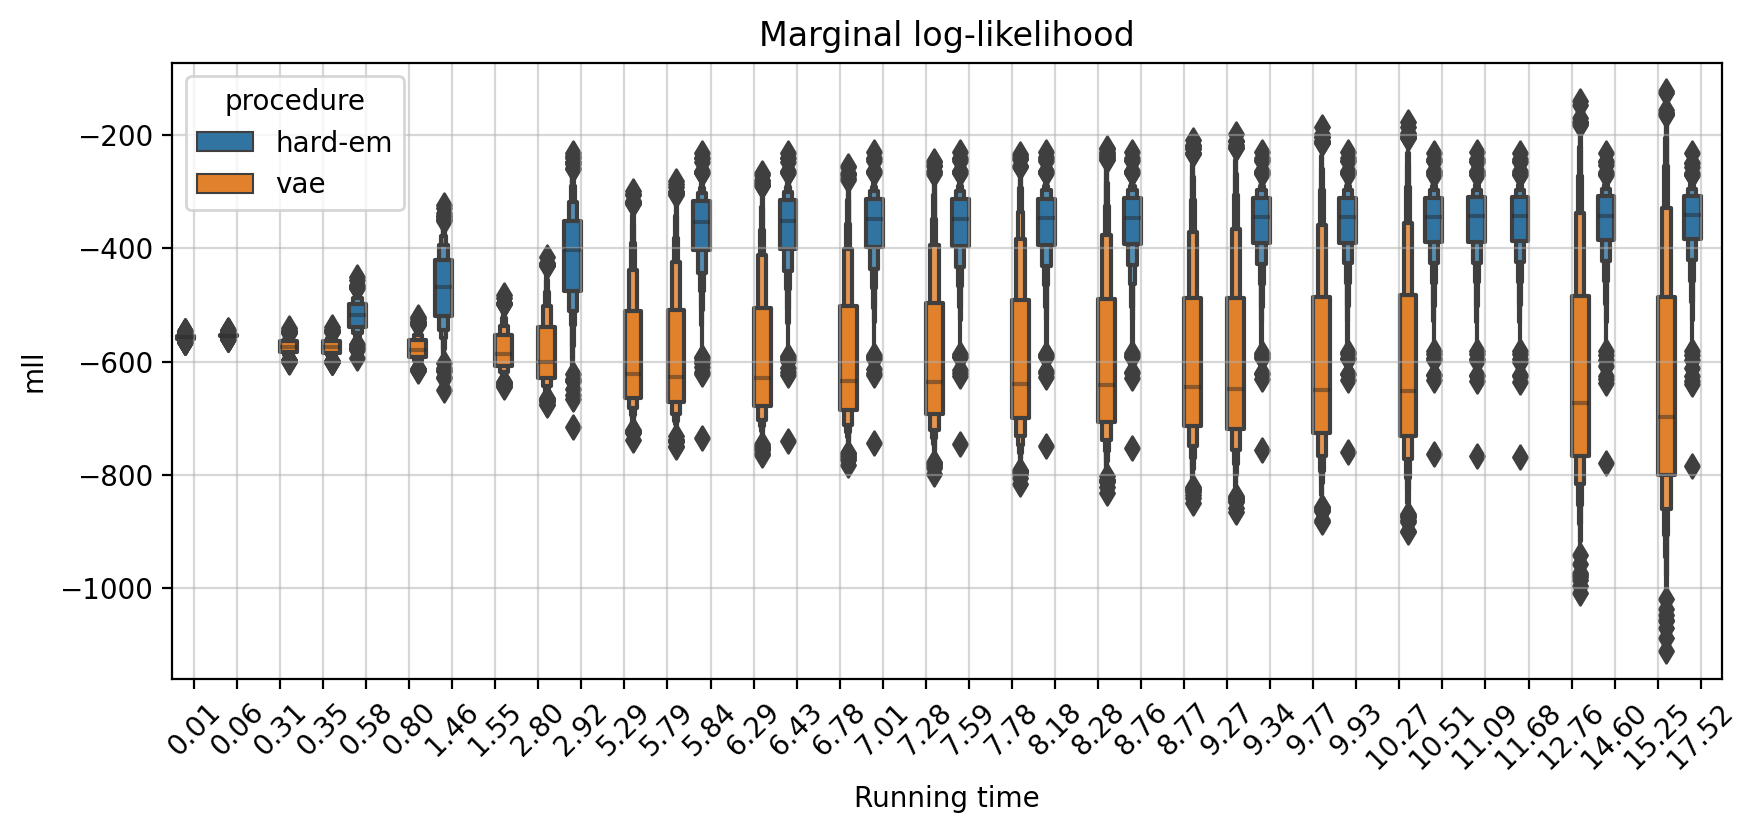

In [82]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x="times", y="mll", hue="procedure", data=df_all)
xpos, xvals = plt.xticks(rotation=45)
xvals = [f"{float(val.get_text()) / 60:0.2f}" for val in xvals]
plt.xticks(xpos, xvals)
plt.title("Marginal log-likelihood")
plt.xlabel("Running time")
plt.grid(alpha=0.5)

## Modifiying configuration

Modifying the number of E-steps

In [97]:
config_lr = deepcopy(config)
config_lr["train"]["hard_em"]["num_its_latent"] = 2

In [98]:
_, *dim_obs = X_train.shape
dim_latent = config["setup"]["dim_latent"]
model_vae = hlax.models.VAEBern(dim_latent, dim_obs, ConvEncoder, ConvDecoder)
model_decoder = ConvDecoder(1, dim_latent)
model_encoder_test = hlax.models.GaussEncoder(dim_latent)

In [99]:
config_vae, config_hardem, config_test = base_vae_hardem.setup(config_lr, model_vae, model_decoder, model_encoder_test)

In [100]:
%%time
res_hemlvm_1 = base_vae_hardem.train_test(key_hardem, X_train, X_test, config_hardem, config_test, 
                        hard_nmll_bern, vmap_neg_iwmll, grad_neg_iwmll_encoder, hlax.hard_em_lvm.train_checkpoints)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 6min 31s, sys: 1min 47s, total: 8min 19s
Wall time: 17min 6s


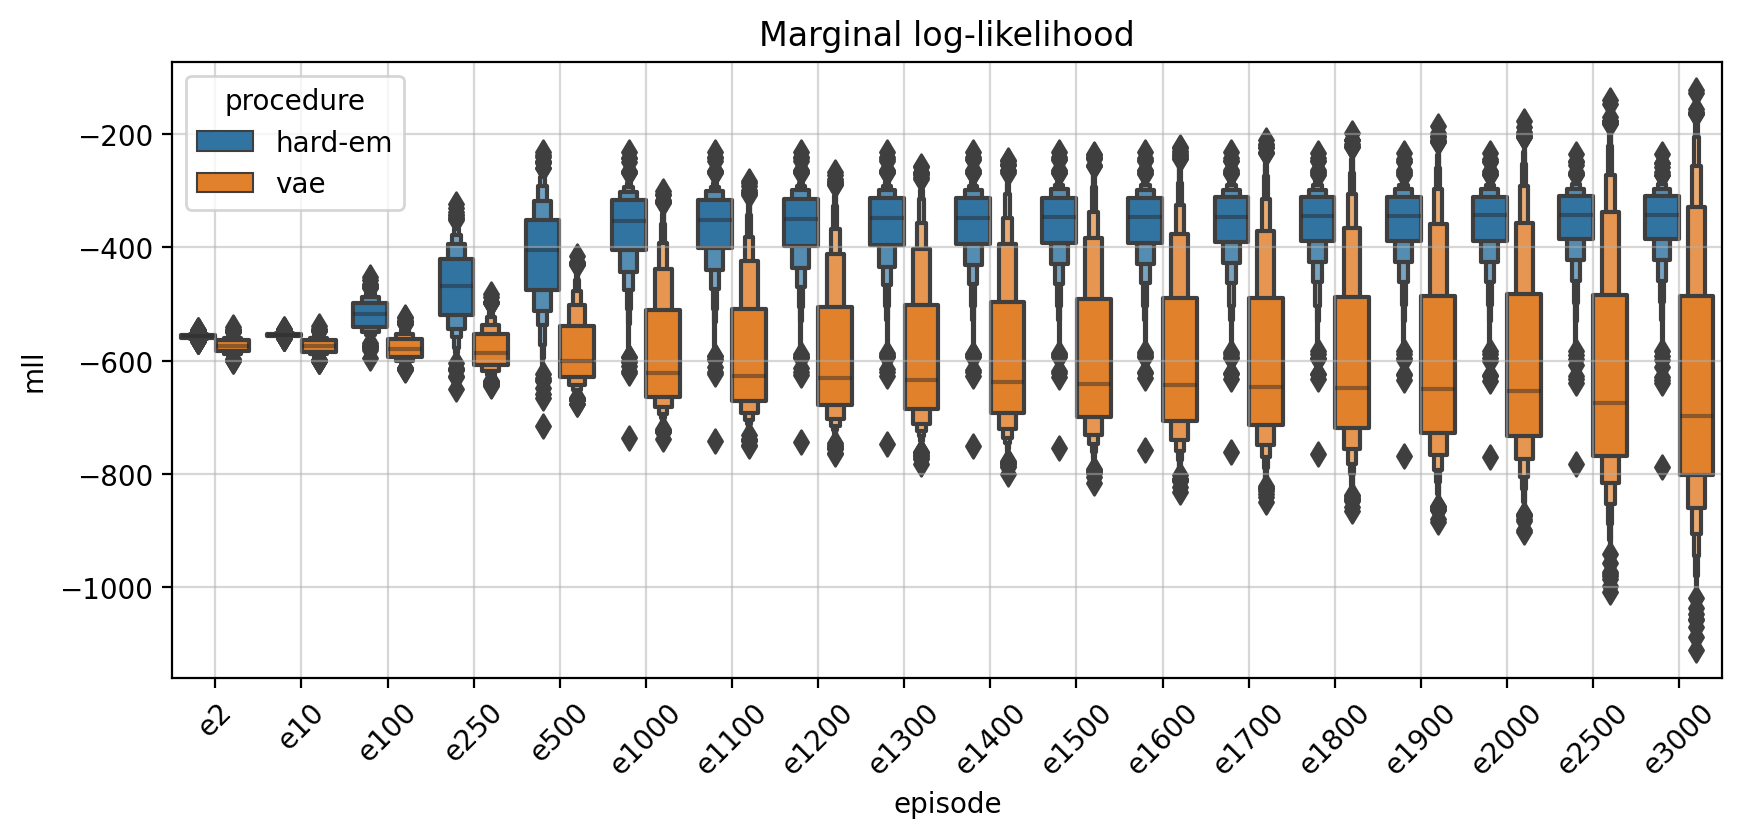

In [112]:
df_vae = build_mll_summary(res_vae, "vae")
df_hem_1 = build_mll_summary(res_hemlvm_1, "hard-em")
df_all = pd.concat([df_hem_1, df_vae])

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x="episode", y="mll", hue="procedure", data=df_all)
plt.title("Marginal log-likelihood")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)

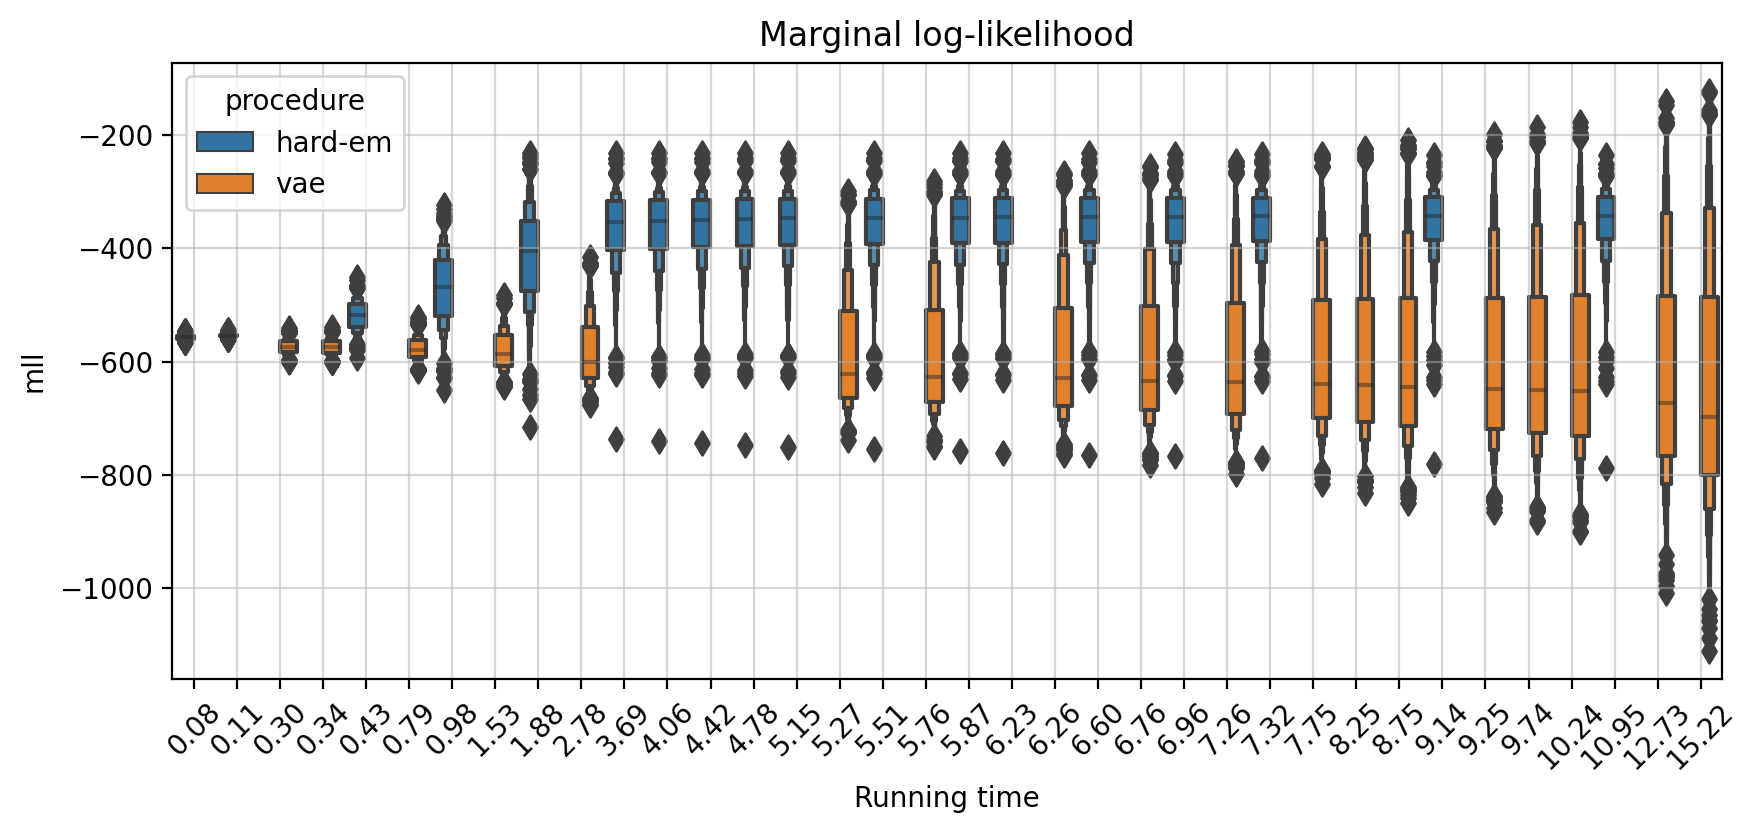

In [108]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxenplot(x="times", y="mll", hue="procedure", data=df_all)
xpos, xvals = plt.xticks(rotation=45)
xvals = [f"{float(val.get_text()) / 60:0.2f}" for val in xvals]
plt.xticks(xpos, xvals)
plt.title("Marginal log-likelihood")
plt.xlabel("Running time")
plt.grid(alpha=0.5)

## Distribution shift

In [83]:
config_lr = deepcopy(config)
config_lr["train"]["num_epochs"] = 1000

In [84]:
_, *dim_obs = X_train.shape
dim_latent = config["setup"]["dim_latent"]
model_vae = hlax.models.VAEBern(dim_latent, dim_obs, ConvEncoder, ConvDecoder)
model_decoder = ConvDecoder(1, dim_latent)
model_encoder_test = hlax.models.GaussEncoder(dim_latent)

In [85]:
X_test_rot = jax.vmap(jnp.rot90)(X_test)[0]

In [86]:
config_vae, config_hardem, config_test = base_vae_hardem.setup(config_lr, model_vae, model_decoder, model_encoder_test)

### VAE training

In [90]:
%%time
res_vae = base_vae_hardem.train_test(key_vae, X_train, X_test_rot, config_vae, config_test,
                     iwae_bern, vmap_neg_iwmll, grad_neg_iwmll_encoder, hlax.vae.train_checkpoints)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 2min 23s, sys: 21 s, total: 2min 44s
Wall time: 5min 35s


### Hard EM - LVM training

In [91]:
%%time
res_hemlvm = base_vae_hardem.train_test(key_hardem, X_train, X_test_rot, config_hardem, config_test, 
                        hard_nmll_bern, vmap_neg_iwmll, grad_neg_iwmll_encoder, hlax.hard_em_lvm.train_checkpoints)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 2min 20s, sys: 38.9 s, total: 2min 59s
Wall time: 6min 2s


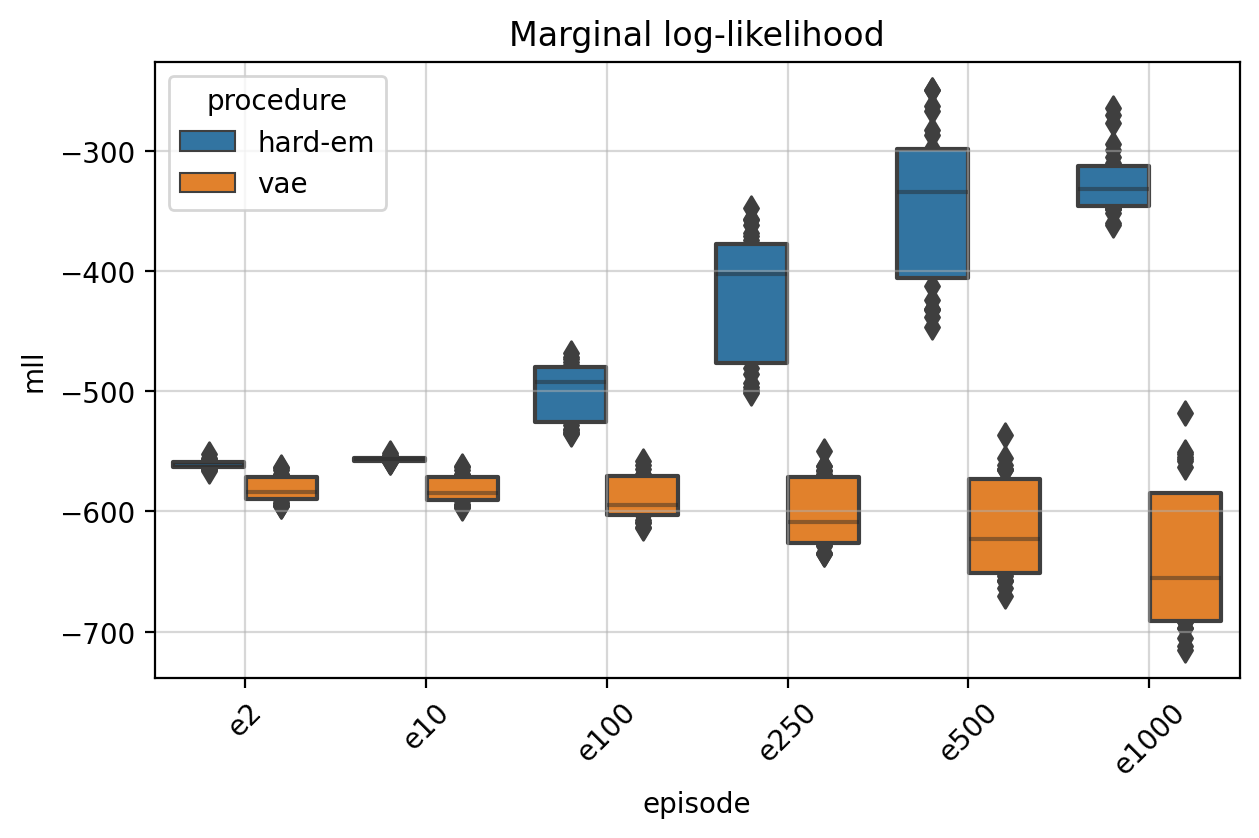

In [92]:
df_vae = build_mll_summary(res_vae, "vae")
df_hem = build_mll_summary(res_hemlvm, "hard-em")
df_all = pd.concat([df_hem, df_vae])

fig, ax = plt.subplots(figsize=(7, 4))
sns.boxenplot(x="episode", y="mll", hue="procedure", data=df_all)
plt.title("Marginal log-likelihood")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)